# 1. 라이브러리 & 데이터 불러오기

## 1. 데이터셋 병합 및 Rename

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font="Malgun Gothic")

df_info = pd.read_csv("../data/raw/big_data_set1_f.csv", encoding="cp949")
df_usage = pd.read_csv("../data/raw/big_data_set2_f.csv", encoding="cp949")
df_customer = pd.read_csv("../data/raw/big_data_set3_f.csv", encoding="cp949")

In [60]:
# 컬럼명 리네이밍
rename_info = {
    "ENCODED_MCT": "num",        # 가맹점ID
    "MCT_BSE_AR": "addr",        # 주소
    "MCT_NM": "name",            # 가맹점명
    "MCT_BRD_NUM": "brand_cd",   # 브랜드코드
    "MCT_SIGUNGU_NM": "sigungu", # 지역(시군구)
    "HPSN_MCT_ZCD_NM": "biz_type", # 업종
    "HPSN_MCT_BZN_CD_NM": "market", # 상권
    "ARE_D": "open",             # 개설일
    "MCT_ME_D": "close"          # 폐업일
}

rename_usage = {
    "ENCODED_MCT": "num",          # 가맹점ID
    "TA_YM": "ym",                 # 기준년월

    "MCT_OPE_MS_CN": "oper_month_grp", # 운영 개월 구간
    "RC_M1_SAA": "sales_grp",      # 매출금액 구간
    "RC_M1_TO_UE_CT": "txn_cnt_grp", # 매출건수 구간
    "RC_M1_UE_CUS_CN": "cust_cnt_grp", # 유니크 고객 수 구간
    "RC_M1_AV_NP_AT": "avg_pay_grp",   # 객단가 구간
    "APV_CE_RAT": "cancel_rate_grp",   # 취소율 구간

    "DLV_SAA_RAT": "delivery_sales_ratio",  # 배달 매출 비율
    "M1_SME_RY_SAA_RAT": "rel_sales_ratio", # 업종 대비 매출 비율
    "M1_SME_RY_UE_CT": "rel_txn_ratio",     # 업종 대비 건수 비율

    "M12_SME_RY_SAA_PCE_RT": "sales_rank_industry", # 업종 내 매출 순위(%)  
    "M12_SME_BZN_SAA_PCE_RT": "sales_rank_market",  # 상권 내 매출 순위(%)  
    "M12_SME_RY_ME_MCT_RAT": "share_sales_industry",# 업종 내 해지 가맹점 비중  
    "M12_SME_BZN_ME_MCT_RAT": "share_sales_market"  # 상권 내 해지 가맹점 비중
}

rename_customer = {
    "ENCODED_MCT": "num",   # 가맹점ID
    "TA_YM": "ym",          # 기준년월

    # 성별/연령별 비율
    "M12_MAL_1020_RAT": "male_20below_ratio",
    "M12_MAL_30_RAT": "male_30_ratio",
    "M12_MAL_40_RAT": "male_40_ratio",
    "M12_MAL_50_RAT": "male_50_ratio",
    "M12_MAL_60_RAT": "male_60plus_ratio",

    "M12_FME_1020_RAT": "female_20below_ratio",
    "M12_FME_30_RAT": "female_30_ratio",
    "M12_FME_40_RAT": "female_40_ratio",
    "M12_FME_50_RAT": "female_50_ratio",
    "M12_FME_60_RAT": "female_60plus_ratio",

    # 고객 행동 지표
    "MCT_UE_CLN_REU_RAT": "revisit_ratio",  # 재방문 고객 비율
    "MCT_UE_CLN_NEW_RAT": "new_ratio",      # 신규 고객 비율

    # 고객 유형 비율
    "RC_M1_SHC_RSD_UE_CLN_RAT": "resident_ratio", # 거주 인구 고객 비율
    "RC_M1_SHC_WP_UE_CLN_RAT": "worker_ratio",    # 직장인 고객 비율
    "RC_M1_SHC_FLP_UE_CLN_RAT": "floating_ratio"  # 유동인구 고객 비율
}


In [61]:

# 1. 리네이밍 적용
df_info.rename(columns=rename_info, inplace=True)
df_usage.rename(columns=rename_usage, inplace=True)
df_customer.rename(columns=rename_customer, inplace=True)


# 2. 날짜 변환
for col in ["open", "close"]:
    df_info[col] = (
        df_info[col]
        .astype(str)                              # 숫자 → 문자열
        .str.replace(r"\D", "", regex=True)       # 숫자 외 문자 제거
        .str.slice(0, 8)                          # 앞 8자리만 사용 (YYYYMMDD)
    )
    df_info[col] = pd.to_datetime(df_info[col], format="%Y%m%d", errors="coerce")

# ym: YYYYMM 숫자 → 문자열 변환 후 파싱
df_usage["ym"]    = pd.to_datetime(df_usage["ym"].astype(str), format="%Y%m", errors="coerce")
df_customer["ym"] = pd.to_datetime(df_customer["ym"].astype(str), format="%Y%m", errors="coerce")

print("usage 기간:", df_usage["ym"].min(), "~", df_usage["ym"].max())
print("customer 기간:", df_customer["ym"].min(), "~", df_customer["ym"].max())


# 3. 월별 데이터 병합
df_monthly = pd.merge(df_usage, df_customer, on=["num", "ym"], how="outer")
print("월별 병합 크기:", df_monthly.shape)


# 4. 기본 정보 붙이기
df_final = pd.merge(df_monthly, df_info, on="num", how="left")


# 5. 폐업 여부 플래그
df_final["is_closed"] = df_final["close"].notnull().astype(int)


# 6. 특수 결측치 치환
for bad in [-999999.9, -999999, "-999999.9", "-999999"]:
    df_final.replace(bad, pd.NA, inplace=True)


# 7. 숫자형 변환 (비율/랭크 등)
ratio_cols = [
    "delivery_sales_ratio", "rel_sales_ratio", "rel_txn_ratio",
    "sales_rank_industry", "sales_rank_market",
    "share_sales_industry", "share_sales_market",
    "revisit_ratio", "new_ratio",
    "resident_ratio", "worker_ratio", "floating_ratio",
    "male_20below_ratio", "male_30_ratio", "male_40_ratio",
    "male_50_ratio", "male_60plus_ratio",
    "female_20below_ratio", "female_30_ratio", "female_40_ratio",
    "female_50_ratio", "female_60plus_ratio",
]
for c in ratio_cols:
    if c in df_final.columns:
        df_final[c] = pd.to_numeric(df_final[c], errors="coerce")


# 8. 범주형 변환
group_cols = [
    "oper_month_grp", "sales_grp", "txn_cnt_grp",
    "cust_cnt_grp", "avg_pay_grp", "cancel_rate_grp"
]
for c in group_cols:
    if c in df_final.columns:
        df_final[c] = df_final[c].astype("category")

# 9. 정렬 (중복 제거는 하지 않음)
df_final = df_final.sort_values(["num", "ym"]).reset_index(drop=True)


# 10. 저장
df_final.to_csv("../data/processed/df_final.csv", index=False, encoding="utf-8-sig")
print(" 최종 데이터 크기:", df_final.shape)
print(df_final.head())


usage 기간: 2023-01-01 00:00:00 ~ 2024-12-01 00:00:00
customer 기간: 2023-01-01 00:00:00 ~ 2024-12-01 00:00:00
월별 병합 크기: (86590, 30)
 최종 데이터 크기: (86590, 39)
          num         ym oper_month_grp           sales_grp  \
0  000F03E44A 2023-01-01       5_75-90%  6_90%초과(하위 10% 이하)   
1  000F03E44A 2023-02-01       5_75-90%  6_90%초과(하위 10% 이하)   
2  000F03E44A 2023-03-01       5_75-90%  6_90%초과(하위 10% 이하)   
3  000F03E44A 2023-04-01       5_75-90%  6_90%초과(하위 10% 이하)   
4  000F03E44A 2023-05-01       5_75-90%  6_90%초과(하위 10% 이하)   

          txn_cnt_grp        cust_cnt_grp         avg_pay_grp cancel_rate_grp  \
0            5_75-90%            5_75-90%            4_50-75%         1_상위1구간   
1  6_90%초과(하위 10% 이하)  6_90%초과(하위 10% 이하)  6_90%초과(하위 10% 이하)             NaN   
2  6_90%초과(하위 10% 이하)  6_90%초과(하위 10% 이하)  6_90%초과(하위 10% 이하)             NaN   
3            5_75-90%            5_75-90%            3_25-50%         1_상위1구간   
4            5_75-90%            5_75-90%  6_90%초과(하위 10% 이하)  

In [62]:
df_final.shape

(86590, 39)

In [80]:
df_final.head()

,num,ym,oper_month_grp,sales_grp,txn_cnt_grp,cust_cnt_grp,avg_pay_grp,cancel_rate_grp,delivery_sales_ratio,rel_sales_ratio,...,revisit_ratio,new_ratio,resident_ratio,worker_ratio,floating_ratio,sigungu,biz_type,market,open,is_franchise
0,000F03E44A,2023-01-01,5_75-90%,6_90%초과(하위 10% 이하),5_75-90%,5_75-90%,4_50-75%,1_상위1구간,NaN,0.5,...,0.0,100.00,0.0,0.0,100.0,서울 성동구,중식-딤섬/중식만두,뚝섬,2022-02-25,0
1,000F03E44A,2023-02-01,5_75-90%,6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),NaN,NaN,0.0,...,0.0,0.00,NaN,NaN,NaN,서울 성동구,중식-딤섬/중식만두,뚝섬,2022-02-25,0
2,000F03E44A,2023-03-01,5_75-90%,6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),NaN,NaN,0.0,...,0.0,0.00,NaN,NaN,NaN,서울 성동구,중식-딤섬/중식만두,뚝섬,2022-02-25,0
3,000F03E44A,2023-04-01,5_75-90%,6_90%초과(하위 10% 이하),5_75-90%,5_75-90%,3_25-50%,1_상위1구간,NaN,1.3,...,0.0,50.00,0.0,100.0,0.0,서울 성동구,중식-딤섬/중식만두,뚝섬,2022-02-25,0
4,000F03E44A,2023-05-01,5_75-90%,6_90%초과(하위 10% 이하),5_75-90%,5_75-90%,6_90%초과(하위 10% 이하),1_상위1구간,NaN,0.0,...,0.0,33.33,0.0,0.0,100.0,서울 성동구,중식-딤섬/중식만두,뚝섬,2022-02-25,0


In [63]:
# 결측치 확인

df_final.isnull().sum()

num                         0
ym                          0
oper_month_grp              0
sales_grp                   0
txn_cnt_grp                 0
cust_cnt_grp                0
avg_pay_grp                 0
cancel_rate_grp          6632
delivery_sales_ratio    57345
rel_sales_ratio             0
M1_SME_RY_CNT_RAT           0
sales_rank_industry         0
sales_rank_market           0
share_sales_industry        0
share_sales_market      21419
male_20below_ratio       2004
male_30_ratio            2004
male_40_ratio            2004
male_50_ratio            2004
male_60plus_ratio        2004
female_20below_ratio     2004
female_30_ratio          2004
female_40_ratio          2004
female_50_ratio          2004
female_60plus_ratio      2004
revisit_ratio            1643
new_ratio                1643
resident_ratio           7327
worker_ratio             7327
floating_ratio           7327
addr                        0
name                        0
brand_cd                74865
sigungu   

- brand_cd는 동일 브랜드 매장 식별을 위한 구분 코드<br>
->num 이라는 고유 키가 있으므로 모델링에는 brand_cd 삭제
- 대신 프랜차이즈 여부 정보는 남겨두면 의미가 있으므로 is_franchise 파생변수 생성

In [64]:
#  가맹점 여부 플래그 생성
df_final["is_franchise"] = df_final["brand_cd"].notna().astype(int)

# brand_cd 컬럼 삭제
df_final.drop(columns=["brand_cd"], inplace=True)

# 확인
print("삭제 후 컬럼 존재 여부:", "brand_cd" in df_final.columns)
print(df_final[["num", "is_franchise"]].head())


삭제 후 컬럼 존재 여부: False
          num  is_franchise
0  000F03E44A             0
1  000F03E44A             0
2  000F03E44A             0
3  000F03E44A             0
4  000F03E44A             0


- close(폐업 날짜), is_closed(폐업 여부) 변수 삭제<br>
*폐업 여부나 폐업일은 아직 일어나지 않은 미래 사건이므로
모델의 입력변수로 사용하면 안 됨*

In [65]:
df_final.drop(columns=["close"], inplace=True)

In [66]:
df_final.drop(columns=["is_closed"], inplace=True)

In [67]:
df_final.shape

(86590, 37)

In [79]:
# 결측치 비율 확인

df_final.isnull().sum()

num                         0
ym                          0
oper_month_grp              0
sales_grp                   0
txn_cnt_grp                 0
cust_cnt_grp                0
avg_pay_grp                 0
cancel_rate_grp          6632
delivery_sales_ratio    57345
rel_sales_ratio             0
M1_SME_RY_CNT_RAT           0
sales_rank_industry         0
sales_rank_market           0
share_sales_industry        0
share_sales_market      21419
male_20below_ratio          0
male_30_ratio               0
male_40_ratio               0
male_50_ratio               0
male_60plus_ratio           0
female_20below_ratio        0
female_30_ratio             0
female_40_ratio             0
female_50_ratio             0
female_60plus_ratio         0
revisit_ratio            1643
new_ratio                1643
resident_ratio           7327
worker_ratio             7327
floating_ratio           7327
sigungu                     0
biz_type                    0
market                  21419
open      

- addr(주소), name(상호명)은 단순 문자열로 모델링에 제외

In [69]:
df_final.drop(columns=["addr", "name"], inplace=True)

- male_/female_ 변수들은 각 변수의 평균으로 대체

In [70]:
cols = [
    "male_20below_ratio", "male_30_ratio", "male_40_ratio", "male_50_ratio", "male_60plus_ratio",
    "female_20below_ratio", "female_30_ratio", "female_40_ratio", "female_50_ratio", "female_60plus_ratio"
]

df_final[cols] = df_final[cols].fillna(df_final[cols].mean())


In [71]:
# 결측치 비율 확인

df_final.isnull().sum()

num                         0
ym                          0
oper_month_grp              0
sales_grp                   0
txn_cnt_grp                 0
cust_cnt_grp                0
avg_pay_grp                 0
cancel_rate_grp          6632
delivery_sales_ratio    57345
rel_sales_ratio             0
M1_SME_RY_CNT_RAT           0
sales_rank_industry         0
sales_rank_market           0
share_sales_industry        0
share_sales_market      21419
male_20below_ratio          0
male_30_ratio               0
male_40_ratio               0
male_50_ratio               0
male_60plus_ratio           0
female_20below_ratio        0
female_30_ratio             0
female_40_ratio             0
female_50_ratio             0
female_60plus_ratio         0
revisit_ratio            1643
new_ratio                1643
resident_ratio           7327
worker_ratio             7327
floating_ratio           7327
sigungu                     0
biz_type                    0
market                  21419
open      

---

In [72]:
df = df_final.copy()

In [73]:
df.head()

,num,ym,oper_month_grp,sales_grp,txn_cnt_grp,cust_cnt_grp,avg_pay_grp,cancel_rate_grp,delivery_sales_ratio,rel_sales_ratio,...,revisit_ratio,new_ratio,resident_ratio,worker_ratio,floating_ratio,sigungu,biz_type,market,open,is_franchise
0,000F03E44A,2023-01-01,5_75-90%,6_90%초과(하위 10% 이하),5_75-90%,5_75-90%,4_50-75%,1_상위1구간,NaN,0.5,...,0.0,100.00,0.0,0.0,100.0,서울 성동구,중식-딤섬/중식만두,뚝섬,2022-02-25,0
1,000F03E44A,2023-02-01,5_75-90%,6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),NaN,NaN,0.0,...,0.0,0.00,NaN,NaN,NaN,서울 성동구,중식-딤섬/중식만두,뚝섬,2022-02-25,0
2,000F03E44A,2023-03-01,5_75-90%,6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),NaN,NaN,0.0,...,0.0,0.00,NaN,NaN,NaN,서울 성동구,중식-딤섬/중식만두,뚝섬,2022-02-25,0
3,000F03E44A,2023-04-01,5_75-90%,6_90%초과(하위 10% 이하),5_75-90%,5_75-90%,3_25-50%,1_상위1구간,NaN,1.3,...,0.0,50.00,0.0,100.0,0.0,서울 성동구,중식-딤섬/중식만두,뚝섬,2022-02-25,0
4,000F03E44A,2023-05-01,5_75-90%,6_90%초과(하위 10% 이하),5_75-90%,5_75-90%,6_90%초과(하위 10% 이하),1_상위1구간,NaN,0.0,...,0.0,33.33,0.0,0.0,100.0,서울 성동구,중식-딤섬/중식만두,뚝섬,2022-02-25,0


In [74]:
df_info.shape

(4185, 9)

In [75]:
df_usage.shape

(86590, 15)

In [76]:
df_customer.shape

(86590, 17)

---

# 2. 데이터 변수 살펴보기

In [77]:
print(df.columns.tolist())

['num', 'ym', 'oper_month_grp', 'sales_grp', 'txn_cnt_grp', 'cust_cnt_grp', 'avg_pay_grp', 'cancel_rate_grp', 'delivery_sales_ratio', 'rel_sales_ratio', 'M1_SME_RY_CNT_RAT', 'sales_rank_industry', 'sales_rank_market', 'share_sales_industry', 'share_sales_market', 'male_20below_ratio', 'male_30_ratio', 'male_40_ratio', 'male_50_ratio', 'male_60plus_ratio', 'female_20below_ratio', 'female_30_ratio', 'female_40_ratio', 'female_50_ratio', 'female_60plus_ratio', 'revisit_ratio', 'new_ratio', 'resident_ratio', 'worker_ratio', 'floating_ratio', 'sigungu', 'biz_type', 'market', 'open', 'is_franchise']


## 1. 키/날짜 변수

In [78]:
# 가맹점 ID를 문자열로 통일
df["num"] = df["num"].astype(str)

# ym → 월 단위(datetime) 변환
df["ym"] = pd.to_datetime(df["ym"]).dt.to_period("M").dt.to_timestamp()

# open / close는 datetime64 유지
print(df[["num","ym","open","close","is_closed"]].head())


KeyError: "['close', 'is_closed'] not in index"

## 2. 구간형 변수

In [ ]:
group_cols = [
    "oper_month_grp", "sales_grp", "txn_cnt_grp",
    "cust_cnt_grp", "avg_pay_grp", "cancel_rate_grp"
]

for c in group_cols:
    if c in df.columns:
        df[c] = df[c].astype("category")

print("구간형 변수 dtype 확인:")
print(df[group_cols].dtypes)


구간형 변수 dtype 확인:
oper_month_grp     category
sales_grp          category
txn_cnt_grp        category
cust_cnt_grp       category
avg_pay_grp        category
cancel_rate_grp    category
dtype: object


## 3. 연속형 수치 변수 (비율)

In [ ]:
ratio_cols = [
    "delivery_sales_ratio", "rel_sales_ratio", "M1_SME_RY_CNT_RAT",
    "sales_rank_industry", "sales_rank_market",
    "share_sales_industry", "share_sales_market",
    "revisit_ratio", "new_ratio",
    "resident_ratio", "worker_ratio", "floating_ratio",
    "male_20below_ratio", "male_30_ratio", "male_40_ratio", 
    "male_50_ratio", "male_60plus_ratio",
    "female_20below_ratio", "female_30_ratio", "female_40_ratio", 
    "female_50_ratio", "female_60plus_ratio"
]

for c in ratio_cols:
    if c in df.columns:
        # 숫자형 변환
        df[c] = pd.to_numeric(df[c], errors="coerce")

        # 음수/비정상 값 NaN 처리
        df.loc[df[c] < 0, c] = np.nan
        df.loc[df[c] > 1000, c] = np.nan

        # NaN → 0으로 채우기 (분석 편의)
        df[c] = df[c].fillna(0)

print("연속형 변수 요약:")
print(df[ratio_cols].describe().T.head())


연속형 변수 요약:
                        count        mean         std  min   25%   50%    75%  \
delivery_sales_ratio  86590.0    9.384783   22.044341  0.0   0.0   0.0    3.4   
rel_sales_ratio       86590.0  128.436716  146.402937  0.0  24.4  81.1  179.1   
M1_SME_RY_CNT_RAT     86590.0  136.754058  164.268819  0.0  20.3  78.4  192.4   
sales_rank_industry   86590.0   31.184643   25.253279  0.1   9.9  23.9   48.2   
sales_rank_market     86590.0   24.070313   22.843491  0.0   1.3  18.9   39.2   

                         max  
delivery_sales_ratio   111.2  
rel_sales_ratio        999.6  
M1_SME_RY_CNT_RAT     1000.0  
sales_rank_industry    100.0  
sales_rank_market       99.6  


## 4. 문자형 변수

In [ ]:
text_cols = ["addr", "name", "brand_cd", "sigungu", "biz_type", "market"]

for c in text_cols:
    if c in df.columns:
        df[c] = df[c].fillna("unknown")

print("문자형 변수 예시:")
print(df[text_cols].head())

문자형 변수 예시:
                  addr  name brand_cd sigungu    biz_type market
0  서울특별시 성동구 왕십리로4가길 9  육육**  unknown  서울 성동구  중식-딤섬/중식만두     뚝섬
1  서울특별시 성동구 왕십리로4가길 9  육육**  unknown  서울 성동구  중식-딤섬/중식만두     뚝섬
2  서울특별시 성동구 왕십리로4가길 9  육육**  unknown  서울 성동구  중식-딤섬/중식만두     뚝섬
3  서울특별시 성동구 왕십리로4가길 9  육육**  unknown  서울 성동구  중식-딤섬/중식만두     뚝섬
4  서울특별시 성동구 왕십리로4가길 9  육육**  unknown  서울 성동구  중식-딤섬/중식만두     뚝섬


In [ ]:
print("데이터 타입별 개수:")
print(df.dtypes.value_counts())
print('---------------------------')
print("\n 최종 데이터 크기:", df.shape)
df.head()


데이터 타입별 개수:
float64           22
object             7
category           5
datetime64[ns]     3
category           1
int32              1
Name: count, dtype: int64
---------------------------

 최종 데이터 크기: (86590, 39)


,num,ym,oper_month_grp,sales_grp,txn_cnt_grp,cust_cnt_grp,avg_pay_grp,cancel_rate_grp,delivery_sales_ratio,rel_sales_ratio,...,floating_ratio,addr,name,brand_cd,sigungu,biz_type,market,open,close,is_closed
0,000F03E44A,2023-01-01,5_75-90%,6_90%초과(하위 10% 이하),5_75-90%,5_75-90%,4_50-75%,1_상위1구간,0.0,0.5,...,100.0,서울특별시 성동구 왕십리로4가길 9,육육**,unknown,서울 성동구,중식-딤섬/중식만두,뚝섬,2022-02-25,NaT,0
1,000F03E44A,2023-02-01,5_75-90%,6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),NaN,0.0,0.0,...,0.0,서울특별시 성동구 왕십리로4가길 9,육육**,unknown,서울 성동구,중식-딤섬/중식만두,뚝섬,2022-02-25,NaT,0
2,000F03E44A,2023-03-01,5_75-90%,6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),NaN,0.0,0.0,...,0.0,서울특별시 성동구 왕십리로4가길 9,육육**,unknown,서울 성동구,중식-딤섬/중식만두,뚝섬,2022-02-25,NaT,0
3,000F03E44A,2023-04-01,5_75-90%,6_90%초과(하위 10% 이하),5_75-90%,5_75-90%,3_25-50%,1_상위1구간,0.0,1.3,...,0.0,서울특별시 성동구 왕십리로4가길 9,육육**,unknown,서울 성동구,중식-딤섬/중식만두,뚝섬,2022-02-25,NaT,0
4,000F03E44A,2023-05-01,5_75-90%,6_90%초과(하위 10% 이하),5_75-90%,5_75-90%,6_90%초과(하위 10% 이하),1_상위1구간,0.0,0.0,...,100.0,서울특별시 성동구 왕십리로4가길 9,육육**,unknown,서울 성동구,중식-딤섬/중식만두,뚝섬,2022-02-25,NaT,0


---

## 1. df_info (데이터셋1)

In [ ]:
df_info.head()

,num,addr,name,brand_cd,sigungu,biz_type,market,open,close
0,16184E93D9,서울 성동구 마장동,성우**,NaN,서울 성동구,축산물,마장동,2013-03-20,NaT
1,4D039EA8B7,서울 성동구 마장동,대보**,NaN,서울 성동구,축산물,마장동,2013-11-22,NaT
2,0074C4990A,서울 성동구 마장동,대용**,NaN,서울 성동구,축산물,마장동,2014-05-12,NaT
3,68308F2746,서울 성동구 마장동,통일**,NaN,서울 성동구,축산물,마장동,2015-11-24,NaT
4,4117EDDE9C,서울 성동구 마장동,한울**,NaN,서울 성동구,축산물,마장동,2015-12-11,NaT


In [ ]:
# 1-1. 기본 현황
print("총 가맹점 수:", df_info.shape[0])
print("운영 중:", (df_info["close"].isna()).sum()) # close가 NaT면 운영 중이라고 간주함.
print("폐업:", (df_info["close"].notna()).sum())

총 가맹점 수: 4185
운영 중: 4058
폐업: 127


In [ ]:
df_info.isna().sum()

num            0
addr           0
name           0
brand_cd    3643
sigungu        0
biz_type       0
market      1047
open           0
close       4058
dtype: int64

### 폐업 가맹점 집중 EDA!!!

In [ ]:
# 폐업 가맹점만 추출
closed_info = df_info[df_info["close"].notna()].copy()
print("폐업 가맹점 수:", closed_info.shape[0])

# 폐업 직전 월(= close 이전 가장 최근 ym) 추출
# closed_last : 폐업일(close) 바로 전에 기록된 월별 이용정보(df_usage)
closed_last = (
    df_usage.merge(closed_info[["num","close"]], on="num")
    .query("ym < close")   # 폐업일 이전 데이터만
    .sort_values(["num","ym"])
    .groupby("num")
    .tail(1)               # 폐업 직전 데이터
)

# 생존 가맹점: 폐업 안한 애들 중 가장 최근 ym 데이터
# alive_last : 운영 중인 가맹점의 가장 최근 관측치
alive_info = df_info[df_info["close"].isna()].copy()
print("생존 가맹점 수:", alive_info.shape[0])
alive_last = (
    df_usage.merge(alive_info[["num"]], on="num")
    .sort_values(["num","ym"])
    .groupby("num")
    .tail(1)
)

폐업 가맹점 수: 127
생존 가맹점 수: 4058


In [ ]:
closed_last.head()

,num,ym,oper_month_grp,sales_grp,txn_cnt_grp,cust_cnt_grp,avg_pay_grp,cancel_rate_grp,delivery_sales_ratio,rel_sales_ratio,M1_SME_RY_CNT_RAT,sales_rank_industry,sales_rank_market,share_sales_industry,share_sales_market,close
10,04393D7C92,2024-12-01,3_25-50%,5_75-90%,5_75-90%,4_50-75%,4_50-75%,1_상위1구간,50.8,9.1,17.5,57.9,0.0,16.2,-999999.9,2025-07-23
25,0507C6C859,2024-12-01,5_75-90%,5_75-90%,5_75-90%,5_75-90%,4_50-75%,1_상위1구간,77.2,3.9,3.8,55.8,57.7,20.2,10.5,2025-08-19
2090,08336C3B85,2024-12-01,3_25-50%,2_10-25%,2_10-25%,2_10-25%,4_50-75%,2_상위2구간,-999999.9,149.8,363.0,15.7,0.0,16.2,-999999.9,2025-07-02
2316,099CBF2425,2023-04-01,6_90%초과(하위 10% 이하),5_75-90%,5_75-90%,5_75-90%,4_50-75%,1_상위1구간,97.4,5.1,6.1,61.3,61.3,16.4,10.2,2023-04-17
44,099CE5DB1F,2024-12-01,6_90%초과(하위 10% 이하),2_10-25%,4_50-75%,3_25-50%,2_10-25%,1_상위1구간,-999999.9,195.9,88.3,34.0,58.8,16.4,11.3,2025-07-30


In [ ]:
closed_info.head()

,num,addr,name,brand_cd,sigungu,biz_type,market,open,close
107,4349A8302A,서울 성동구 장터길 23,롯데******,햄버거1,서울 성동구,햄버거,금남시장,2015-08-12,2025-08-18
159,FCAF2BC53E,서울 성동구 마조로 21.,빽다******,커피전문점4,서울 성동구,커피전문점,한양대,2015-07-31,2025-08-18
232,2889D57BC9,서울 성동구 성수동2가,영남***,NaN,서울 성동구,식품 제조,성수,2011-12-14,2025-07-31
246,19DC3A560D,서울 성동구 동호로 102.,더건***************,NaN,서울 성동구,식품 제조,NaN,2015-03-12,2025-07-17
273,57B4E2F996,서울 성동구 마장로 228.,장충********,NaN,서울 성동구,한식-육류/고기,왕십리,2015-11-23,2025-08-11


In [ ]:
alive_info.head()

,num,addr,name,brand_cd,sigungu,biz_type,market,open,close
0,16184E93D9,서울 성동구 마장동,성우**,NaN,서울 성동구,축산물,마장동,2013-03-20,NaT
1,4D039EA8B7,서울 성동구 마장동,대보**,NaN,서울 성동구,축산물,마장동,2013-11-22,NaT
2,0074C4990A,서울 성동구 마장동,대용**,NaN,서울 성동구,축산물,마장동,2014-05-12,NaT
3,68308F2746,서울 성동구 마장동,통일**,NaN,서울 성동구,축산물,마장동,2015-11-24,NaT
4,4117EDDE9C,서울 성동구 마장동,한울**,NaN,서울 성동구,축산물,마장동,2015-12-11,NaT


C:\Users\windows\AppData\Local\Temp\ipykernel_21460\453645751.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(closed_last["rel_sales_ratio"], label="폐업 직전", shade=True)
c:\Users\windows\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\windows\AppData\Local\Temp\ipykernel_21460\453645751.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(alive_last["rel_sales_ratio"], label="생존 최근", shade=True)
c:\Users\windows\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be remove

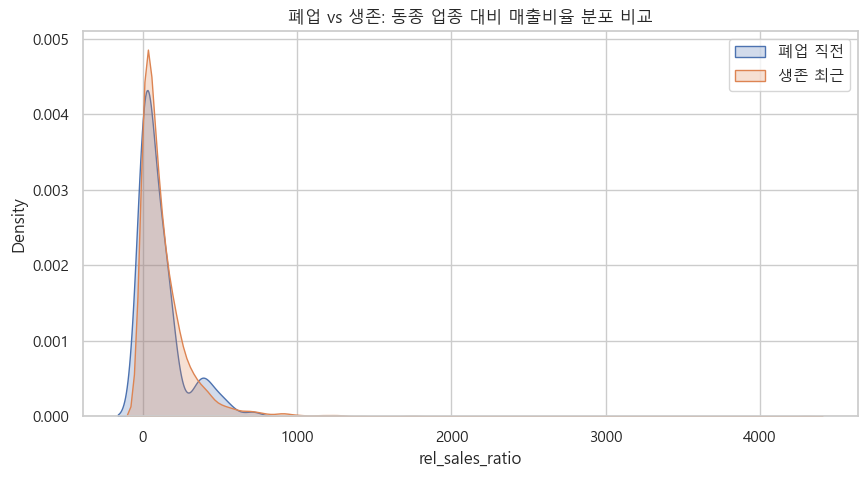

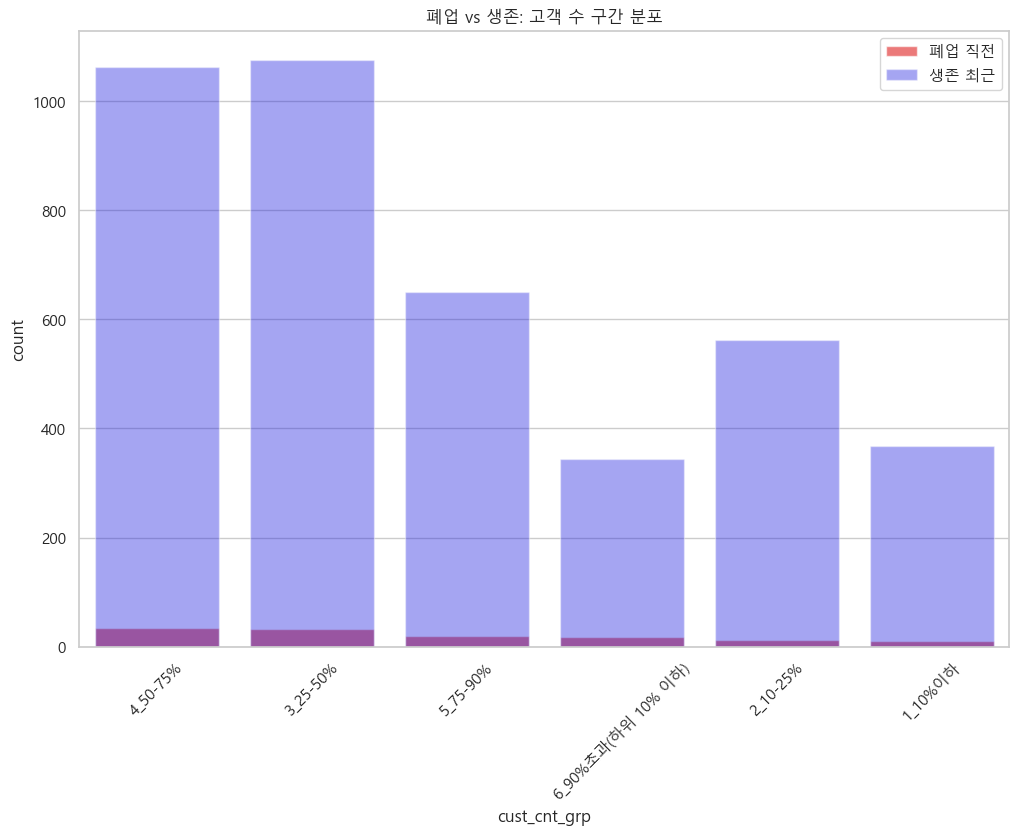

In [ ]:
# 매출 비교
plt.figure(figsize=(10,5))
sns.kdeplot(closed_last["rel_sales_ratio"], label="폐업 직전", shade=True)
sns.kdeplot(alive_last["rel_sales_ratio"], label="생존 최근", shade=True)
plt.title("폐업 vs 생존: 동종 업종 대비 매출비율 분포 비교")
plt.legend()
plt.show()

# 고객 수 구간 분포 비교 (countplot)
plt.figure(figsize=(12,8))
sns.countplot(data=closed_last, x="cust_cnt_grp", order=closed_last["cust_cnt_grp"].value_counts().index, color="red", alpha=0.6, label="폐업 직전")
sns.countplot(data=alive_last, x="cust_cnt_grp", order=closed_last["cust_cnt_grp"].value_counts().index, color="blue", alpha=0.4, label="생존 최근")
plt.title("폐업 vs 생존: 고객 수 구간 분포")
plt.legend()
plt.xticks(rotation=45)
plt.show()


폐업 점포 평균 고객 수 구간: 3.63
생존 점포 평균 고객 수 구간: 3.54


c:\Users\windows\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


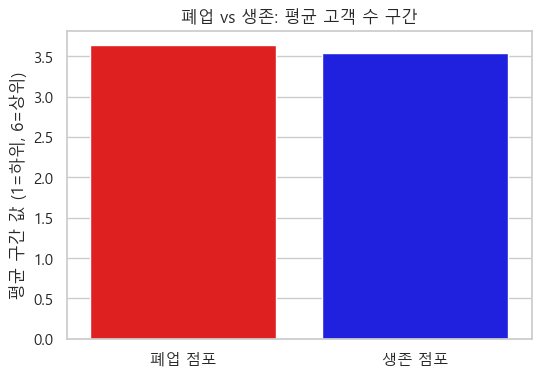

In [ ]:
## 폐업 vs. 생존의 평균 고객 수 구간
# 1) 구간 순서를 숫자로 매핑 (낮을수록 고객 수 적음)
grp_order = {
    "1_하위1구간": 1,
    "2_10-25%": 2,
    "3_25-50%": 3,
    "4_50-75%": 4,
    "5_75-90%": 5,
    "6_90%초과(상위10%)": 6
}

# 2) 매핑 적용
closed_last["cust_cnt_grp_num"] = closed_last["cust_cnt_grp"].map(grp_order)
alive_last["cust_cnt_grp_num"]  = alive_last["cust_cnt_grp"].map(grp_order)

# 3) 평균 구하기
closed_mean = closed_last["cust_cnt_grp_num"].mean()
alive_mean  = alive_last["cust_cnt_grp_num"].mean()

print("폐업 점포 평균 고객 수 구간:", round(closed_mean,2))
print("생존 점포 평균 고객 수 구간:", round(alive_mean,2))

# 4) 시각화 (막대비교)
plt.figure(figsize=(6,4))
sns.barplot(x=["폐업 점포","생존 점포"], y=[closed_mean, alive_mean], palette=["red","blue"])
plt.title("폐업 vs 생존: 평균 고객 수 구간")
plt.ylabel("평균 구간 값 (1=하위, 6=상위)")
plt.show()


c:\Users\windows\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\windows\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


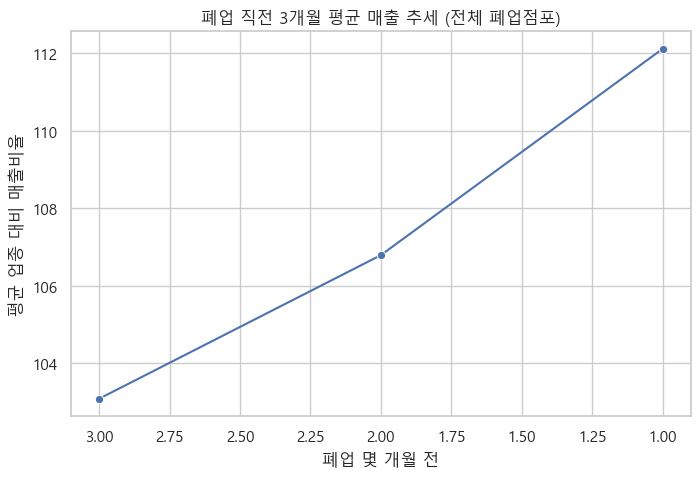

In [ ]:
## 폐업 직전 매출 추세 (폐업 전 3개월)

# 1) 폐업점포 데이터에 폐업 직전 3개월만 남기기
tmp = (
    df_usage.merge(closed_info[["num","close"]], on="num")
    .query("ym < close")  # 폐업일 이전
)

# 폐업월 기준으로 몇 개월 전인지 계산
tmp["months_before_close"] = ((tmp["close"].dt.to_period("M") - tmp["ym"].dt.to_period("M")).apply(lambda x: x.n))

# 2) 직전 3개월만 필터링
tmp_last3 = tmp[tmp["months_before_close"].between(1,3)]

# 3) 폐업점포 전체 평균 계산
avg_trend = (
    tmp_last3.groupby("months_before_close")["rel_sales_ratio"]
    .mean()
    .reset_index()
    .sort_values("months_before_close")
)

# 4) 시각화
plt.figure(figsize=(8,5))
sns.lineplot(data=avg_trend, x="months_before_close", y="rel_sales_ratio", marker="o")
plt.gca().invert_xaxis()  # x축: 3개월 전 → 1개월 전 → 폐업월 순서로 보이게
plt.title("폐업 직전 3개월 평균 매출 추세 (전체 폐업점포)")
plt.xlabel("폐업 몇 개월 전")
plt.ylabel("평균 업종 대비 매출비율")
plt.show()



In [ ]:
## 고객 구조 변화 (재방문율·신규율)

# 1) 폐업점포 직전 데이터 (df 기반)
closed_last_cust = (
    df.merge(closed_info[["num","close"]], on="num")
    .query("ym < close")       # 폐업 전 데이터만
    .sort_values(["num","ym"])
    .groupby("num")
    .tail(1)                   # 폐업 직전 데이터
)

# 2) 생존점포 최근 데이터 (df 기반)
alive_last_cust = (
    df.merge(alive_info[["num"]], on="num")
    .sort_values(["num","ym"])
    .groupby("num")
    .tail(1)                   # 가장 최근 데이터
)

# 3) 재방문율 비교
plt.figure(figsize=(12,5))
sns.kdeplot(closed_last_cust["revisit_ratio"], label="폐업 직전 - 재방문율", shade=True)
sns.kdeplot(alive_last_cust["revisit_ratio"], label="생존 최근 - 재방문율", shade=True)
plt.title("폐업 vs 생존: 재방문율 비교")
plt.legend()
plt.show()

# 4) 신규고객율 비교
plt.figure(figsize=(12,5))
sns.kdeplot(closed_last_cust["new_ratio"], label="폐업 직전 - 신규율", shade=True)
sns.kdeplot(alive_last_cust["new_ratio"], label="생존 최근 - 신규율", shade=True)
plt.title("폐업 vs 생존: 신규 고객 비율 비교")
plt.legend()
plt.show()



UndefinedVariableError: name 'close' is not defined

In [ ]:
## 5. 업종 대비 경쟁력 비교
# 업종별 평균 대비 상대 매출
industry_avg = df_usage.groupby(["ym","biz_type"])["rel_sales_ratio"].mean().reset_index()

closed_last_ind = closed_last.merge(df_info[["num","biz_type"]], on="num") \
    .merge(industry_avg, on=["ym","biz_type"], suffixes=("_store","_industry"))

closed_last_ind["gap"] = closed_last_ind["rel_sales_ratio_store"] - closed_last_ind["rel_sales_ratio_industry"]

plt.figure(figsize=(10,5))
sns.histplot(closed_last_ind["gap"], bins=30, kde=True)
plt.axvline(0, color="red", linestyle="--")
plt.title("폐업 가맹점: 업종 평균 대비 매출 격차 (직전월)")
plt.show()


---

In [ ]:
## df_final에서 폐업데이터만 추출

In [ ]:
# 폐업 가맹점만 추출
df_closed = df_final[df_final["close"].notna()].copy()

print("폐업 데이터 크기:", df_closed.shape)
print(df_closed.head())

폐업 데이터 크기: (2334, 39)
             num         ym oper_month_grp sales_grp txn_cnt_grp cust_cnt_grp  \
1696  04393D7C92 2023-01-01       4_50-75%  4_50-75%    4_50-75%     4_50-75%   
1697  04393D7C92 2023-02-01       4_50-75%  4_50-75%    4_50-75%     4_50-75%   
1698  04393D7C92 2023-03-01       4_50-75%  4_50-75%    4_50-75%     4_50-75%   
1699  04393D7C92 2023-04-01       4_50-75%  5_75-90%    4_50-75%     4_50-75%   
1700  04393D7C92 2023-05-01       4_50-75%  4_50-75%    4_50-75%     4_50-75%   

     avg_pay_grp cancel_rate_grp  delivery_sales_ratio  rel_sales_ratio  ...  \
1696    3_25-50%         1_상위1구간                  17.7             59.0  ...   
1697    4_50-75%         1_상위1구간                  30.5             43.7  ...   
1698    3_25-50%         1_상위1구간                  32.9             52.2  ...   
1699    3_25-50%         1_상위1구간                  44.4             32.5  ...   
1700    3_25-50%  6_상위6구간(하위1구간)                  20.9             50.1  ...   

      floa

In [ ]:
df_info.columns

Index(['num', 'addr', 'name', 'brand_cd', 'sigungu', 'biz_type', 'market',
       'open', 'close', 'calc_close', 'lifetime_months'],
      dtype='object')

In [ ]:
# 폐업 점포만 추출
df_info_closed = df_info[df_info["close"].notna()].copy()

print("폐업 점포 수:", df_info_closed.shape[0])
print(df_info_closed.head())


폐업 점포 수: 127
            num             addr               name brand_cd sigungu  \
107  4349A8302A    서울 성동구 장터길 23           롯데******     햄버거1  서울 성동구   
159  FCAF2BC53E   서울 성동구 마조로 21.           빽다******   커피전문점4  서울 성동구   
232  2889D57BC9   서울  성동구  성수동2가              영남***      NaN  서울 성동구   
246  19DC3A560D  서울 성동구 동호로 102.  더건***************      NaN  서울 성동구   
273  57B4E2F996  서울 성동구 마장로 228.         장충********      NaN  서울 성동구   

     biz_type market       open      close calc_close  lifetime_months  
107       햄버거   금남시장 2015-08-12 2025-08-18 2025-08-18              120  
159     커피전문점    한양대 2015-07-31 2025-08-18 2025-08-18              121  
232     식품 제조     성수 2011-12-14 2025-07-31 2025-07-31              163  
246     식품 제조    NaN 2015-03-12 2025-07-17 2025-07-17              124  
273  한식-육류/고기    왕십리 2015-11-23 2025-08-11 2025-08-11              117  



업종별 폐업 점포 수:
 biz_type
한식-단품요리일반    18
카페           12
한식-육류/고기     11
치킨            7
축산물           7
양식            7
베이커리          6
분식            6
커피전문점         5
한식-해물/생선      5
Name: count, dtype: int64


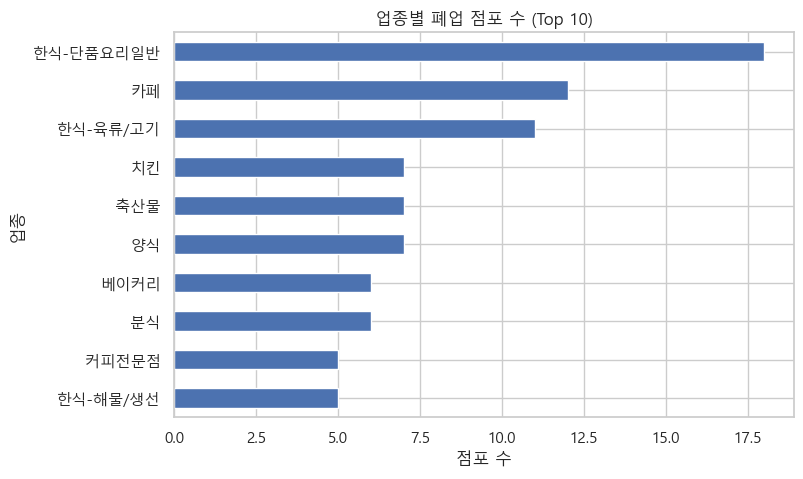

In [ ]:
# 1. 업종별 폐업 점포 수
industry_counts = df_info_closed["biz_type"].value_counts()
print("\n업종별 폐업 점포 수:\n", industry_counts.head(10))

industry_counts.head(10).plot(kind="barh", figsize=(8,5), title="업종별 폐업 점포 수 (Top 10)")
plt.xlabel("점포 수")
plt.ylabel("업종")
plt.gca().invert_yaxis()
plt.show()


상권별 폐업 점포 수:
 market
성수        21
왕십리       15
한양대       14
뚝섬         9
금남시장       7
신금호        6
답십리        6
마장동        6
행당         3
장한평자동차     2
Name: count, dtype: int64


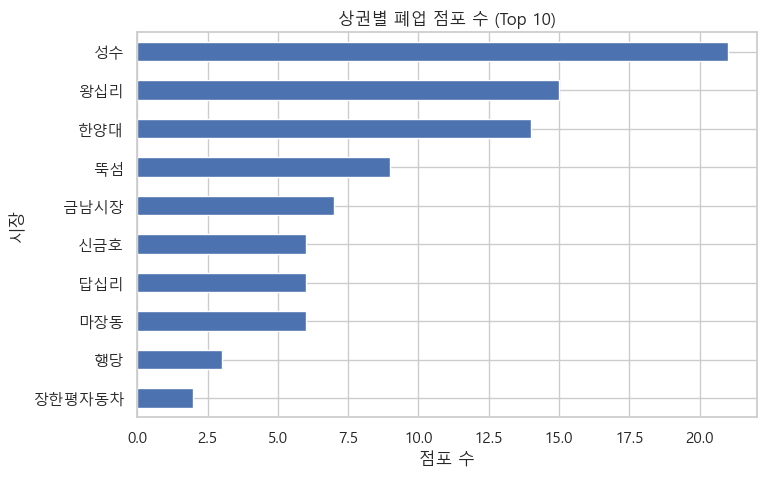

In [ ]:

# 2. 상권/시장별 폐업 점포 수
market_counts = df_info_closed["market"].value_counts()
print("\n상권별 폐업 점포 수:\n", market_counts.head(10))

market_counts.head(10).plot(kind="barh", figsize=(8,5), title="상권별 폐업 점포 수 (Top 10)")
plt.xlabel("점포 수")
plt.ylabel("시장")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# 3. 평균 생존 개월 수
avg_lifetime = df_info_closed["lifetime_months"].mean()
print(f"\n전체 폐업 점포 평균 생존기간: {avg_lifetime:.1f}개월")



전체 폐업 점포 평균 생존기간: 54.4개월



업종별 평균 생존기간:
 biz_type
아이스크림/빙수      7.00
포장마차         11.00
식료품          16.75
기타세계요리       17.00
구내식당/푸드코트    22.00
도시락          24.00
일식당          24.80
중식-훠궈/마라탕    31.00
와인샵          32.00
호프/맥주        33.00
Name: lifetime_months, dtype: float64


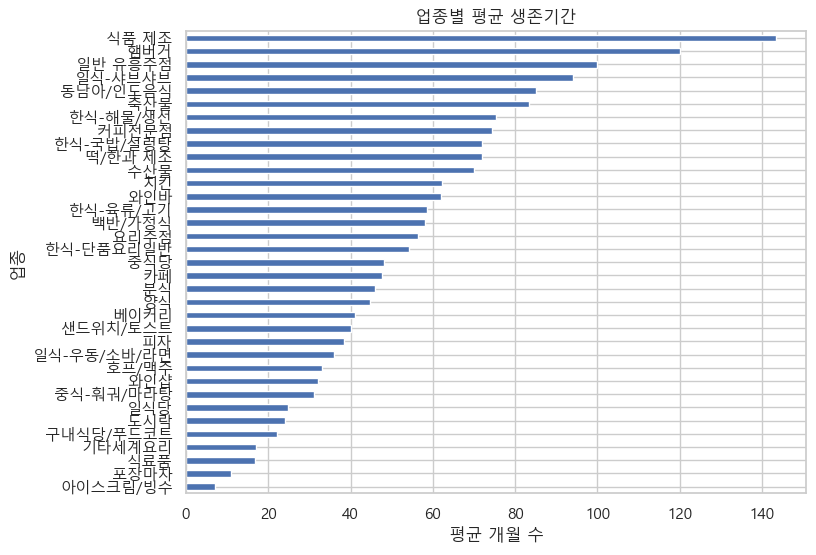

In [ ]:
# 업종별 평균 생존 개월 수
industry_lifetime = (
    df_info_closed.groupby("biz_type")["lifetime_months"]
    .mean()
    .sort_values()
)
print("\n업종별 평균 생존기간:\n", industry_lifetime.head(10))
industry_lifetime.plot(kind="barh", figsize=(8,6), title="업종별 평균 생존기간")
plt.xlabel("평균 개월 수")
plt.ylabel("업종")
plt.show()


In [ ]:
# 4. 조기폐업(24개월 이하) 비율
early_fail_ratio = (df_info_closed["lifetime_months"] <= 24).mean() * 100
print(f"\n조기폐업(24개월 이하) 비율: {early_fail_ratio:.1f}%")



조기폐업(24개월 이하) 비율: 24.4%


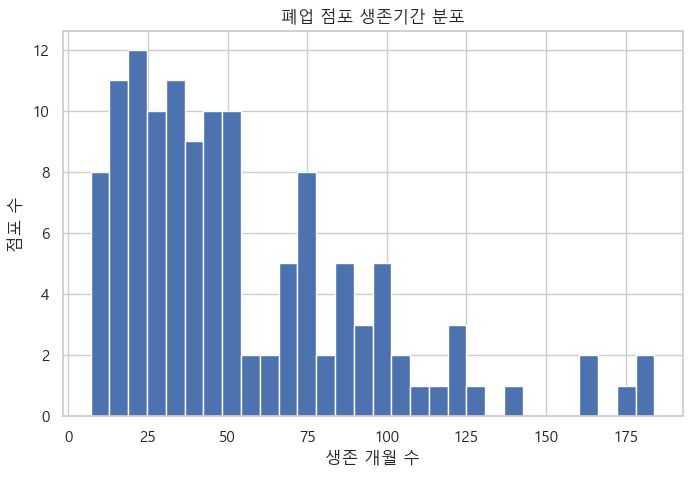

In [ ]:

# 5. 생존기간 분포
df_info_closed["lifetime_months"].hist(bins=30, figsize=(8,5))
plt.title("폐업 점포 생존기간 분포")
plt.xlabel("생존 개월 수")
plt.ylabel("점포 수")
plt.show()

---

In [ ]:
df_usage.columns

Index(['num', 'ym', 'oper_month_grp', 'sales_grp', 'txn_cnt_grp',
       'cust_cnt_grp', 'avg_pay_grp', 'cancel_rate_grp',
       'delivery_sales_ratio', 'rel_sales_ratio', 'M1_SME_RY_CNT_RAT',
       'sales_rank_industry', 'sales_rank_market', 'share_sales_industry',
       'share_sales_market'],
      dtype='object')

In [ ]:
# 1. 폐업 점포 리스트 가져오기 (df_info 기준)
closed_ids = df_info[df_info["close"].notna()][["num", "close"]]


In [ ]:
# 2. usage 데이터와 병합
df_usage_closed = pd.merge(df_usage, closed_ids, on="num", how="inner")

In [ ]:
df_usage_closed.head()

,num,ym,oper_month_grp,sales_grp,txn_cnt_grp,cust_cnt_grp,avg_pay_grp,cancel_rate_grp,delivery_sales_ratio,rel_sales_ratio,M1_SME_RY_CNT_RAT,sales_rank_industry,sales_rank_market,share_sales_industry,share_sales_market,close,months_to_close
0,04393D7C92,2023-05-01,4_50-75%,4_50-75%,4_50-75%,4_50-75%,3_25-50%,6_상위6구간(하위1구간),20.9,50.1,23.3,37.7,0.0,9.5,-999999.9,2025-07-23,26
1,04393D7C92,2023-10-01,3_25-50%,4_50-75%,4_50-75%,4_50-75%,3_25-50%,6_상위6구간(하위1구간),31.7,61.3,22.4,41.6,0.0,11.5,-999999.9,2025-07-23,21
2,04393D7C92,2024-06-01,3_25-50%,5_75-90%,4_50-75%,4_50-75%,3_25-50%,1_상위1구간,33.0,22.3,25.4,48.2,0.0,17.3,-999999.9,2025-07-23,13
3,04393D7C92,2024-11-01,3_25-50%,4_50-75%,4_50-75%,4_50-75%,3_25-50%,1_상위1구간,18.6,29.6,29.1,50.8,0.0,16.9,-999999.9,2025-07-23,8
4,04393D7C92,2024-01-01,3_25-50%,4_50-75%,4_50-75%,4_50-75%,3_25-50%,1_상위1구간,39.7,28.4,28.9,45.9,0.0,17.5,-999999.9,2025-07-23,18


In [ ]:
unique_num_count = df_usage_closed["num"].nunique()
print("폐업 가맹점 수 (unique num):", unique_num_count)

폐업 가맹점 수 (unique num): 127


---

In [ ]:
# df_final이 num 단위 기본정보 안 붙은 상태라면,
df_final = df_final.merge(
    df_info[["num","lifetime_months"]],
    on="num",
    how="left"
)


In [ ]:
# 1. 폐업일 붙이기
df_usage_closed = pd.merge(
    df_usage,
    df_info[["num", "close", "lifetime_months"]],
    on="num",
    how="inner"
)

# 2. 폐업까지 남은 개월 수 계산 (NaT 안전하게 처리)
def months_diff(row):
    if pd.notna(row["close"]) and pd.notna(row["ym"]):
        return (row["close"].to_period("M") - row["ym"].to_period("M")).n
    else:
        return None

df_usage_closed["months_to_close"] = df_usage_closed.apply(months_diff, axis=1)

print(df_usage_closed[["num", "ym", "close", "months_to_close"]].head())


          num         ym close  months_to_close
0  000F03E44A 2024-04-01   NaT              NaN
1  000F03E44A 2023-12-01   NaT              NaN
2  000F03E44A 2024-09-01   NaT              NaN
3  000F03E44A 2023-10-01   NaT              NaN
4  000F03E44A 2023-08-01   NaT              NaN


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 3. 폐업 직전 3개월 평균값만 추출
features = (
    df_usage_closed[df_usage_closed["months_to_close"] <= 3]
    .groupby("num")
    .agg({
        "rel_sales_ratio": "mean",
        "sales_rank_market": "mean",
        "delivery_sales_ratio": "mean"
    })
    .reset_index()
)

# 4. 업력 추가
features = features.merge(df_info[["num","lifetime_months"]], on="num", how="left")
features = features.dropna()

# 5. 스케일링
X = features.drop(columns=["num"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. KMeans 클러스터링
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
features["cluster"] = kmeans.fit_predict(X_scaled)

# 7. 클러스터별 평균 특성 요약 (수치형만)
cluster_summary = features.drop(columns=["num"]).groupby("cluster").mean(numeric_only=True)
print(cluster_summary)

# 클러스터별 개수
print("\n클러스터별 점포 수:")
print(features["cluster"].value_counts())


         rel_sales_ratio  sales_rank_market  delivery_sales_ratio  \
cluster                                                             
0              12.447222          56.419444        -555528.680556   
1              84.642857          10.133929         -53532.569643   
2             569.100000           1.766667        -999999.900000   
3             133.287500           9.475000        -999999.900000   

         lifetime_months  
cluster                   
0              53.333333  
1              33.500000  
2             184.000000  
3              47.400000  

클러스터별 점포 수:
cluster
1    14
3    10
0     9
2     1
Name: count, dtype: int64


c:\Users\windows\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
